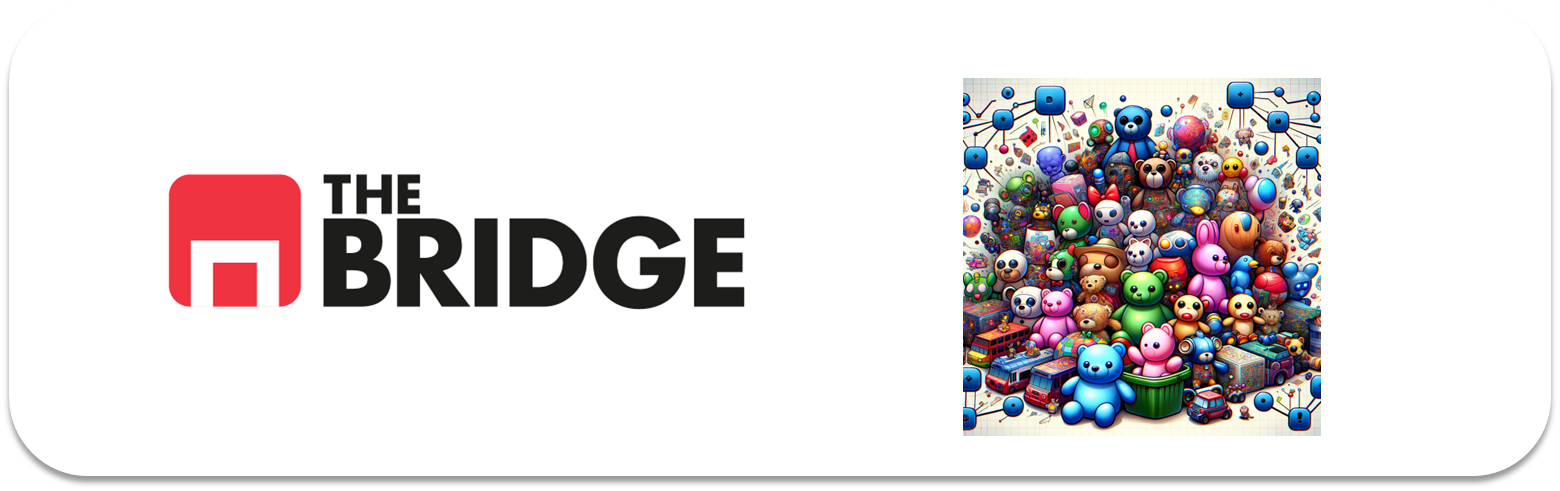

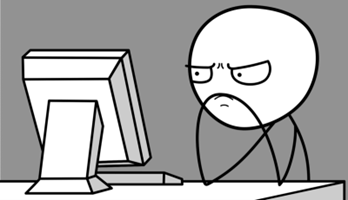

Para ejercitarte y afianzar lo aprendido sobre **K-Means**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import pandas as pd
import importlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import Toolbox_datascience as tds
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
importlib.reload(tds)

<module 'Toolbox_datascience' from 'c:\\Users\\rodri\\Git_Repositories\\ONLINE_DS_THEBRIDGE_ROD\\Sprint_13\\Unidad_01\\Ejercicios_Workout\\Toolbox_datascience.py'>

### Entendiendo el problema de negocio

En este notebook vamos a hacer un análisis de datos tirando de clusterizaciones para evaluar si existen grupos en nuestros productos, en este caso medicamentos, y posteriormente poder etiquetarlos. Poseemos información como rating, efectividad, efectos secundarios, entre otros.

### Ejercicio 1

Importa los datos, "./data/drugLibTrain_raw.tsv", que contiene un dataset con diferentes fármacos, sus efectos y ratings de los clientes de dichos fármacos. Realiza una inspección preliminar y quita las columnas que consideres innecesarias.

In [3]:
df = pd.read_csv('./data/drugLibTrain_raw.tsv', sep='\t')
df.head()

,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [4]:
tds.describe_df(df)

COL_N,Unnamed: 0,urlDrugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
DATA_TYPE,int64,object,int64,object,object,object,object,object,object
MISSINGS (%),0.0,0.0,0.0,0.0,0.0,0.0,0.6,2.4,0.4
UNIQUE_VALUES,3107,502,10,5,5,1426,3031,2813,3046
CARDIN (%),1.0,0.16,0.0,0.0,0.0,0.46,0.97,0.88,0.98


### Ejercicio 2: MiniEDA

Como es un problema no supervisado (vamos a intentar agrupar los medicamentos sin tener una referencia o target inicial), no hay split, vamos directos al miniEDA. Analiza qué variables son descartables en función de su porcentaje de cardinalidad. Es decir obten la cardinalidad y su porcentaje para cada posible feature y crea un dataset nuevo descartando las features que creas conveniente. NOTA: Como simplificación, descarta la columna con url.

In [5]:
tds.clasifica_variables(df,20,0.5)

,nombre_variable,tipo_sugerido
0,Unnamed: 0,Numérica Continua
1,urlDrugName,Categórica de excesiva cardinalidad
2,rating,Categórica
3,effectiveness,Categórica
4,sideEffects,Categórica
5,condition,Categórica de excesiva cardinalidad
6,benefitsReview,Categórica de excesiva cardinalidad
7,sideEffectsReview,Categórica de excesiva cardinalidad
8,commentsReview,Categórica de excesiva cardinalidad


In [6]:
df.drop(['Unnamed: 0', 'urlDrugName', 'condition', 'benefitsReview', 'sideEffectsReview', 'commentsReview'], axis=1, inplace=True)

In [7]:
df.head()   

,rating,effectiveness,sideEffects
0,4,Highly Effective,Mild Side Effects
1,1,Highly Effective,Severe Side Effects
2,10,Highly Effective,No Side Effects
3,3,Marginally Effective,Mild Side Effects
4,2,Marginally Effective,Severe Side Effects


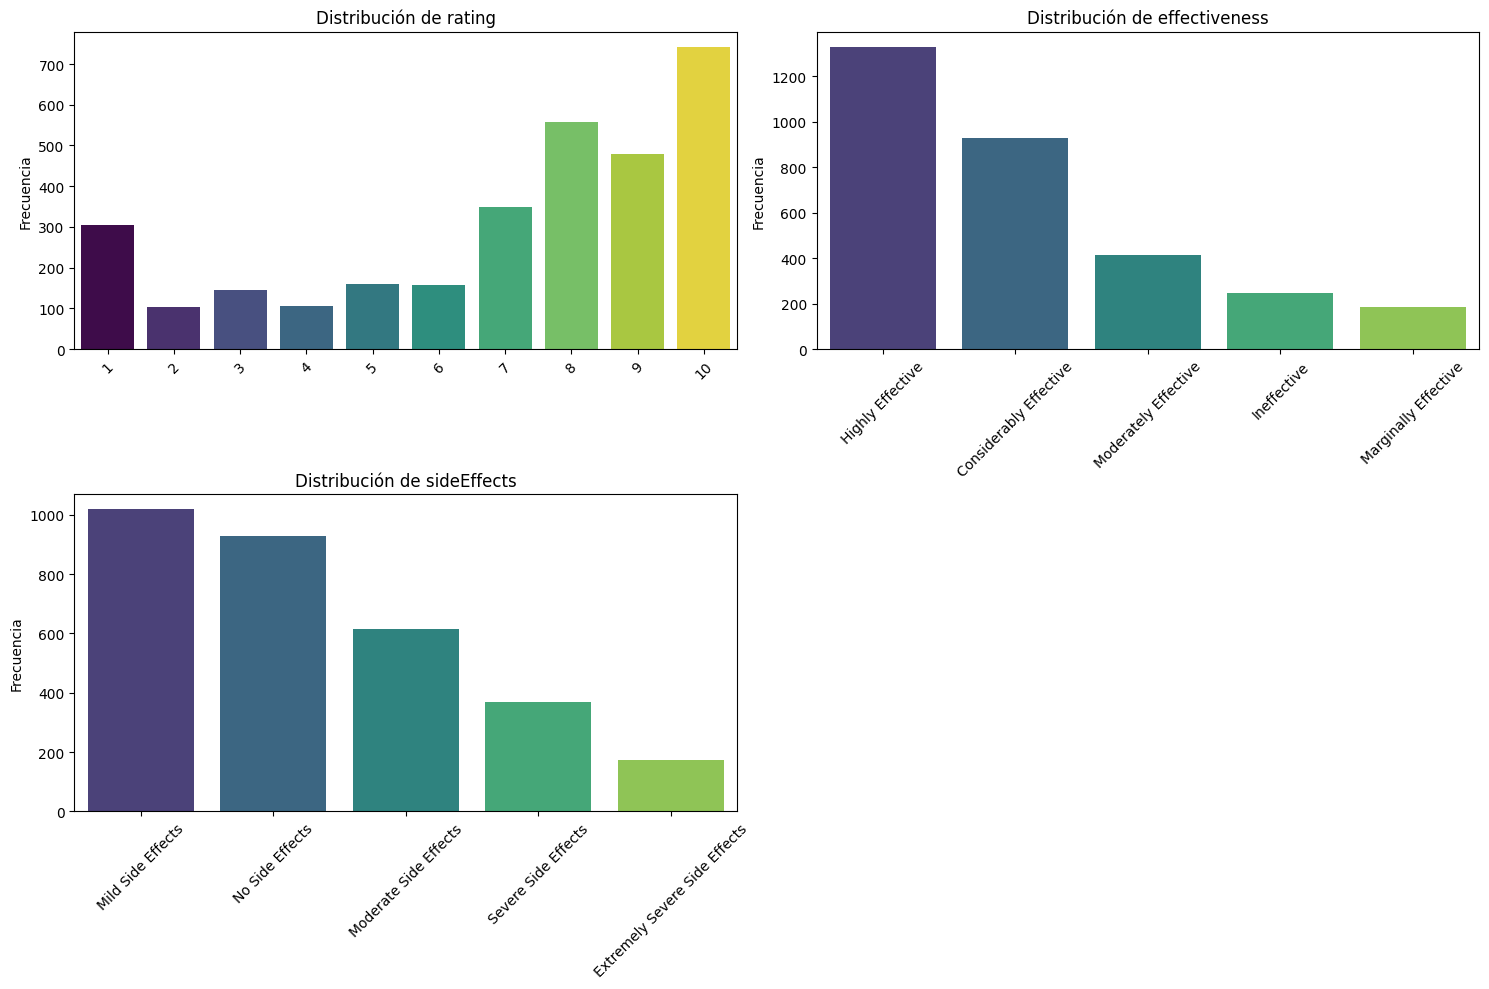

In [8]:
tds.pinta_distribucion_categoricas(df,df.columns)

### Ejercicio 3

Construye un train set (llámalo X) sólo con las features que hayas seleccionado del ejercicio anterior (es decir las que no hayas descartado como posibles features) 

In [9]:
features = ["rating", "effectiveness", "sideEffects"]

# Crear una copia del dataset solo con las columnas necesarias
X = df[features].copy()




### Ejercicio 4 

Trasforma las features que consideres necesario (categóricas y numéricas) y luego aplica el escalado que consideres necesario.

In [10]:
# Aplicar Label Encoding a las variables categóricas
label_encoder = LabelEncoder()
X["effectiveness"] = label_encoder.fit_transform(X["effectiveness"])
X["sideEffects"] = label_encoder.fit_transform(X["sideEffects"])

# Aplicar StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convertir de nuevo en DataFrame con los nombres de columnas originales
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Mostrar las primeras filas para verificar
print(X_scaled.head())

     rating  effectiveness  sideEffects
0 -1.023494      -0.229536    -0.954733
1 -2.044907      -0.229536     1.658029
2  1.019330      -0.229536     0.787108
3 -1.363965       1.291077    -0.954733
4 -1.704436       1.291077     1.658029


### Ejercicio 5: Otención de K, aproximación visual

Analiza la relación entre features (con scatter plots) una vez transformadas para comprobar si existe visualmente algún indicio del número de clústeres que podríamos estar buscando. Por otro lado este análisis nos puede hacer descartar alguna feature o generar una nueva

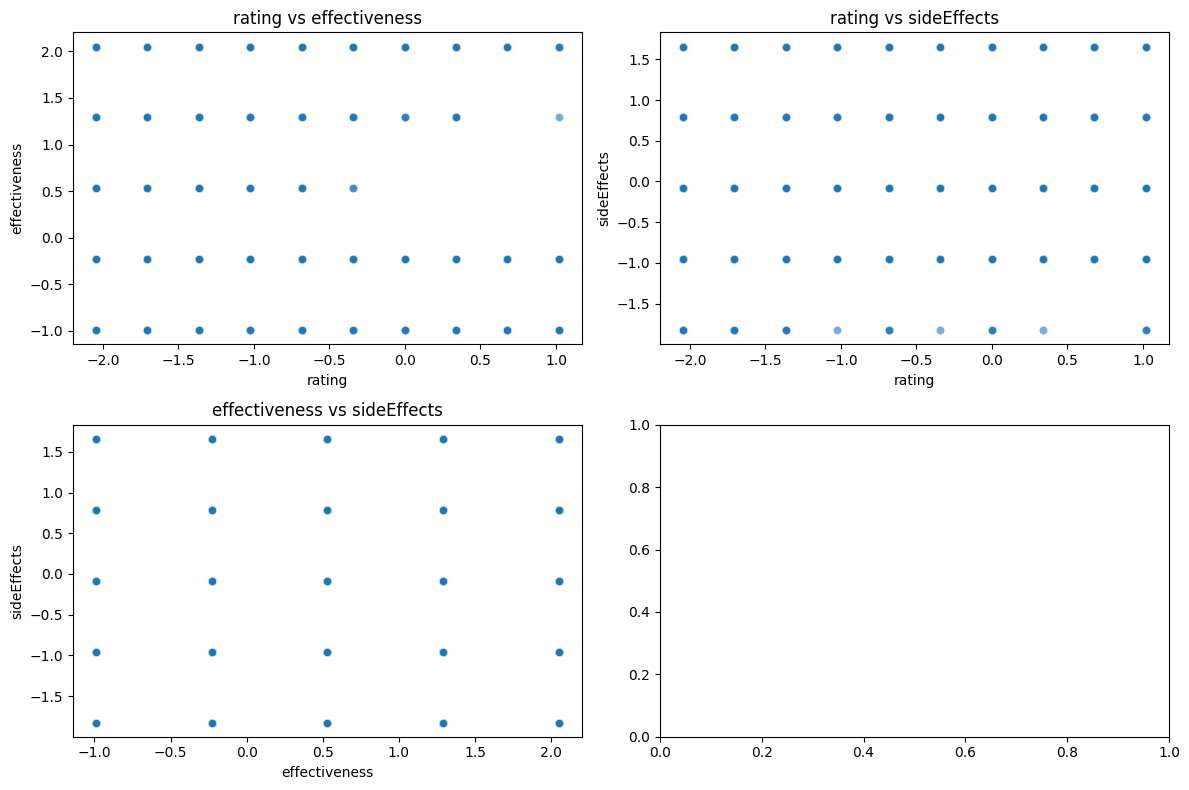

In [11]:
tds.plot_numeric_relationships(X_scaled)

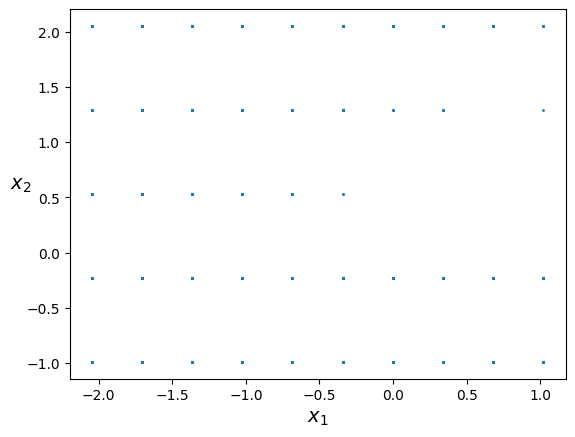

In [12]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

plot_clusters(X_scaled.values)

### Ejercicio 6: Obtención de K, método del codo

Evalua diferentes valores K y escoge uno a partir del método del codo/elbow de inercia.

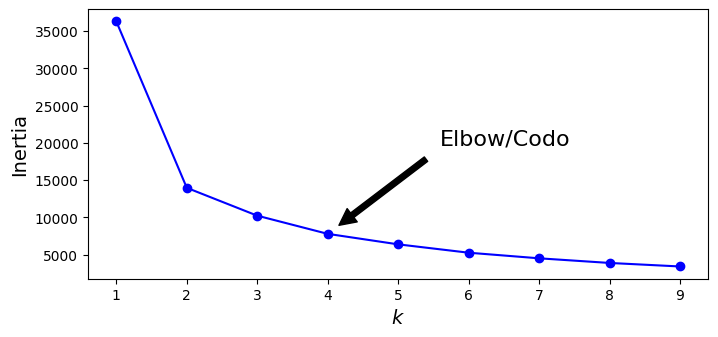

In [13]:
kmeans_per_k = [KMeans(n_clusters=k, random_state= 42, n_init = 25).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow/Codo',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

### Ejercicio 7: Obtención de K, Score de Silueta

Comprueba el ajuste de k obteniendo el k que maximiza el score de silueta y pinta un gráfico de la evolución de dicho score con k. Usa los valores de k que hayas probado en el ejercicio anterior.

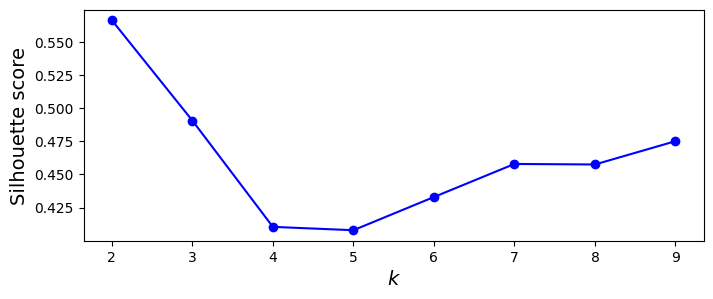

In [14]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()


### Ejercicio 8: Obtención de K, diagrama de silueta

Para completar el estudio de k, muestra el diagramde silueta para k=2,3,4,5 y decide con este datos y los anteriores el valor de k a probar. NOTA: En la realidad, podríamos probar perfectamente k=2 y k=3 y luego que "Negocio" decidiera cuál le es más útil, aquí lo completamos por practicar todo lo aprendido

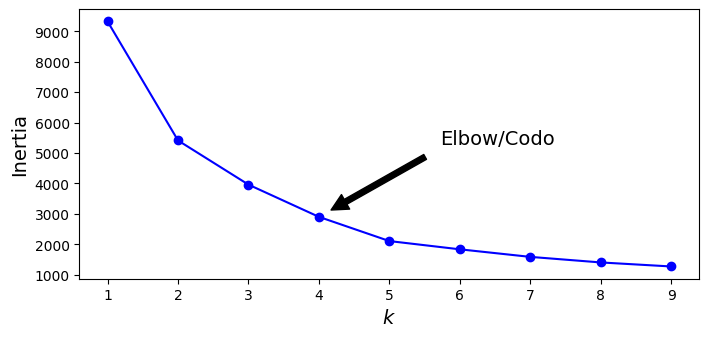

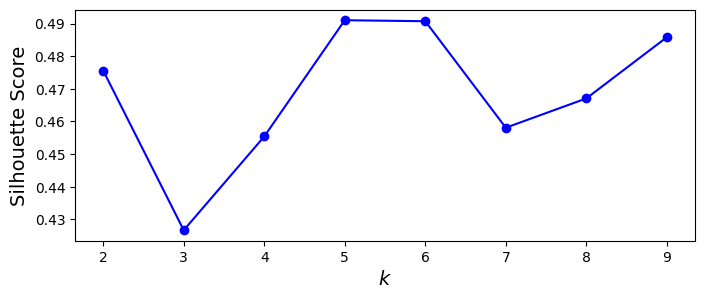

([9321.000000000002,
  5411.419730317892,
  3961.3631656380758,
  2902.895195933131,
  2107.832992618708,
  1837.0348936135838,
  1588.7022734547033,
  1405.9841015083161,
  1273.6055382535312],
 [0.475593349764122,
  0.4266741801153043,
  0.45540376275758243,
  0.4910295846866806,
  0.49072197936993733,
  0.4580898836835541,
  0.46706528914560613,
  0.48582265257725804])

In [15]:
tds.evaluate_kmeans(X_scaled                                     )

### Ejercico 9:

En general, una diferencia entre el proceso de construcción de un modelo no supervisado y un supervisado es que el ajuste de algunos hiperparámetros (como el número de clústeres) es anterior a la construcción del modelo. Por eso, construye un K-means para el valor (o valores) de K escogidos.

### Ejercicio 10

Vamos a comprobar resultados, analizando los valores medios y distribución de cada uno de los clústeres para el k óptimo. Si tuvieras más de un posible valor de k a probar, analiza aquí el de mayor score de silueta. Y utiliza el siguiente ejercicio para el otro. Además de hacer un describe de las features por clúster, pinta estos con un pairplot considerando sideEffects y rating como x e y (o viceversa) y el clúster como hue (color). Compara el resultado con los clústeres sugeridos en el ejercicio 5.

### Ejercicio 11, EXTRA: Más valores de K

Repite el análisis del ejercicio 10 para un K diferente pero que consideres que tiene sentido aplicar.